### Data Preparation Logistic Regression
Logistic Regression requires special data preparation that allows increase the quality of the model

In [1]:
import pandas as pd
import numpy as np 
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from scipy import stats

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import roc_auc_score

TARGET_FEATURE_NAME = 'open_account_flg'
warnings.filterwarnings('ignore')

# Disabling exponent numbers format
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
# Data Loading 
data = pd.read_csv('D:/AI-Projects/Machine_Learning/ENG/Clients_Credit_Prediction/data/credit_init_data.csv', sep=';', encoding='cp1251')
data.drop('client_id', axis='columns', inplace=True) # Drop client_id
data.head()

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
0,M,NaN,NaN,UMN,"59998,00",10,1.600,NaN,GRD,КРАСНОДАРСКИЙ КРАЙ,30000.000,1.000,1.000,0
1,F,NaN,MAR,UMN,"10889,00",6,1.100,NaN,NaN,МОСКВА,NaN,2.000,0.000,0
2,M,32.000,MAR,SPC,"10728,00",12,1.100,NaN,NaN,ОБЛ САРАТОВСКАЯ,NaN,5.000,0.000,0
3,F,27.000,NaN,SPC,"12009,09",12,1.100,NaN,NaN,ОБЛ ВОЛГОГРАДСКАЯ,NaN,2.000,0.000,0
4,M,45.000,NaN,SPC,NaN,10,1.100,"0,421385",SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,NaN,1.000,0.000,0


### Features Description
- `gender`: client gender
- `age`: client age
- `marital_status`: client maritial status
- `job_position`: client employment field
- `credit_sum`: credit sum
- `credit_mont`: credit period in months
- `tariff_id`: id of tariff
- `score_shk`: bank inner scoring value/estimate
- `education`: client education
- `living_region`: client living region
- `monthly_income`: client monthly income
- `credit_count`: number of credits that a client had 
- `overdue_credit_count`: number of overdue credits that a client had
- `open_account_flg`: value that describes wether a credit bank account has been opened by the bank or not 

### Sparse Categorical Features Preprocessing
Let's preprocess categorical features with sparse categories

In [3]:
# Process job_position feature
threshold = 100
jobs_cat_dist = data['job_position'].value_counts()
cat_to_unite = jobs_cat_dist[jobs_cat_dist <= threshold].index.to_list()

# Create new category OTHER
data['job_position'][data['job_position'].isin(cat_to_unite)] = 'OTHER'

# Process tariff_id
threshold = 100
tariff_cat_dist = data['tariff_id'].value_counts()
cat_to_unite = tariff_cat_dist[tariff_cat_dist <= threshold].index.to_list()

# Create new category 100
data['tariff_id'][data['tariff_id'].isin(cat_to_unite)] = 100

In [4]:
# Missing values
data.isna().sum()

gender                     0
age                        3
marital_status             3
job_position               0
credit_sum                 2
credit_month               0
tariff_id                  0
score_shk                  7
education                  5
living_region            192
monthly_income             5
credit_count            9230
overdue_credit_count    9230
open_account_flg           0
dtype: int64

### Train/Test Split
First of all, **we split the data and only then will deal with missing values**

In [5]:
train_data = data.sample(frac=0.7, random_state=23)
test_data = data.drop(train_data.index)

print('Train Data Shape: ', train_data.shape)
print('Test Data Shape: ', test_data.shape)

Train Data Shape:  (119522, 14)
Test Data Shape:  (51224, 14)


### Data Preprocessing
Let's impute missing values

In [6]:
def preprocess_data(df):
    # Missing values indicator for overdue_credit_count feature
    df['is_overdue_credit_count_missing'] = df['overdue_credit_count'].isna().map({True: 1, False: 0})
    df['is_overdue_credit_count_missing'] = df['is_overdue_credit_count_missing'].astype('object')
    
    # Impute by median
    columns_to_median = [
        'age', 'credit_sum', 'score_shk',
        'monthly_income', 'credit_count', 'overdue_credit_count'
    ]
    for column in columns_to_median:
        if df[column].dtype == 'O': # Transform str into float
            df[column] = df[column].str.replace(',', '.').astype('float')
        df[column].fillna(train_data[column].median(), inplace=True)
        
    # Impute by mode
    columns_to_mode = ['marital_status', 'education']
    for column in columns_to_mode:
        df[column].fillna(train_data[column].mode()[0], inplace=True)
        
    # Impute by a new category 'UNKNOWN'
    columns_to_unknown = [
        'gender', 'job_position', 'tariff_id', 'living_region'
    ]
    for column in columns_to_unknown:
        df[column].fillna('unknown', inplace=True)
        df[column] = df[column].astype('str')        
    return df

In [7]:
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

print('NaN Train: ', train_data.isna().sum().sum())
print('NaN Test: ', test_data.isna().sum().sum())

NaN Train:  0
NaN Test:  0


### Continuous Features Normality
It is important for regression analysis to have normally distributed features. **Let's check normality of continuous features**

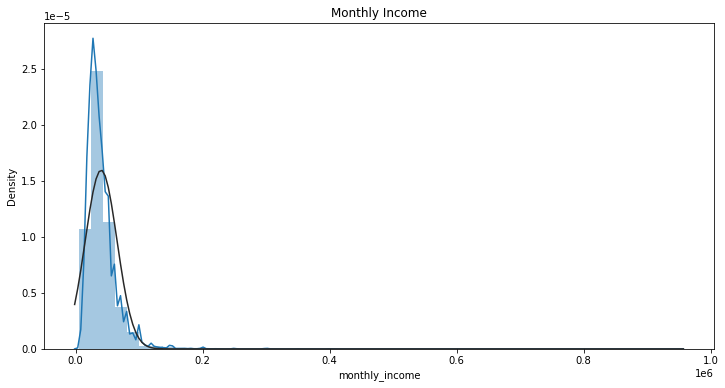

In [8]:
plt.figure(figsize=(12, 6))
plt.title('Monthly Income')
sns.distplot(train_data['monthly_income'], fit=norm);

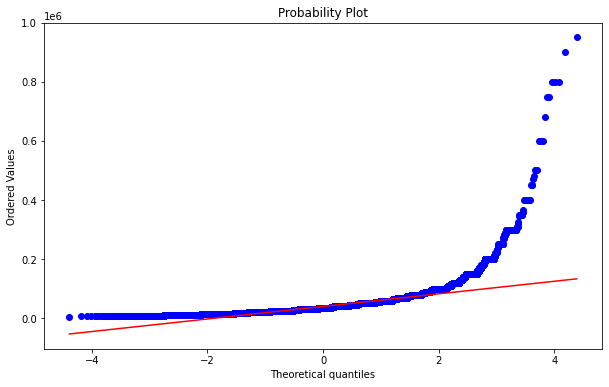

In [9]:
# Q-Q Plot
plt.figure(figsize=(10, 6))
stats.probplot(train_data['monthly_income'], plot=plt);

From the graphs above we can see that **the distribution is right-skewed and has sharp top.** Besides, there are other techniques for normality checking:
- `Skew Coefficient`
- `Kurtosis Coefficient`

**Positive `Skew Coefficient` means that the distribution is right-skewed, negative - left-skewed**

**Positive `Kurtosis Coefficient` meanst that the top is sharp, negative - gentle**

Normally distributed data has zero skewness and kurtosis values

In [10]:
print('Monthly Income')
print('Skewness: ', train_data['monthly_income'].skew())
print('Kurtosis: ', train_data['monthly_income'].kurtosis())

Monthly Income
Skewness:  5.439495172660602
Kurtosis:  94.99317447405467


let's try normalizing the distribution. There are the following techniques:
- Squre/Cubic Root
- Log Transformation (preffered)

When applying `log transformation` we add a constant value to exclude zero values. Squre root is often taken from a value module

### Log Transformation


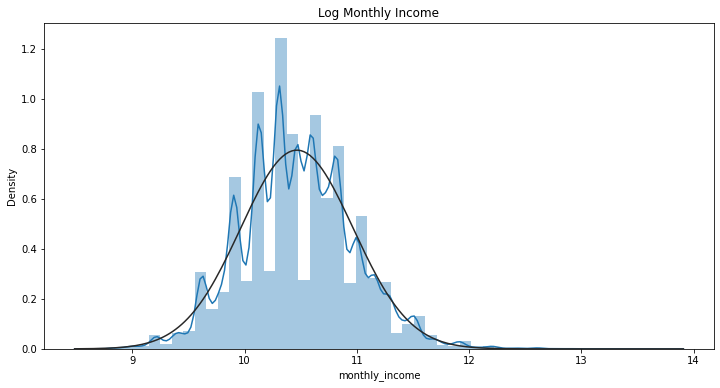

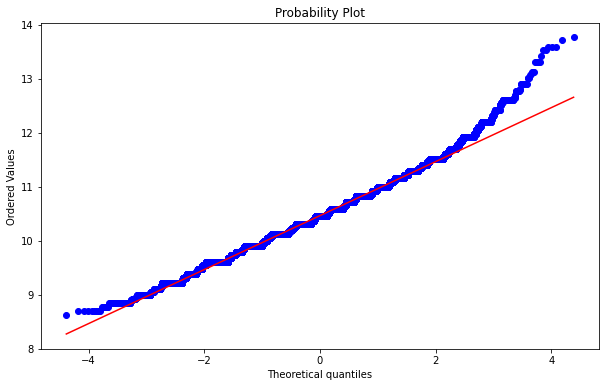

In [11]:
# Apply log transformation
constant = 0.001
log_transformed_feature = np.log(train_data['monthly_income'] + constant)

plt.figure(figsize=(12, 6))
plt.title('Log Monthly Income')
sns.distplot(log_transformed_feature, fit=norm)

plt.figure(figsize=(10, 6))
stats.probplot(log_transformed_feature, plot=plt);

**After applying log transformation the feature looks more normally distributed that before**

In [12]:
print('Log Monthly Income')
print('Skewness: ', log_transformed_feature.skew())
print('Kurtosis: ', log_transformed_feature.kurtosis())

Log Monthly Income
Skewness:  0.2514546878431147
Kurtosis:  0.5712979488000931


### Square Root Transformation

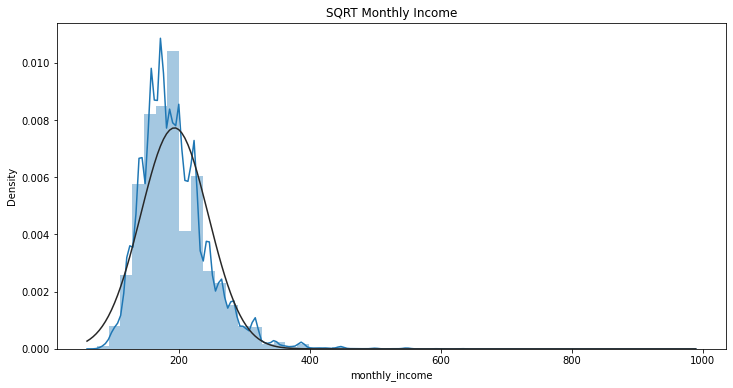

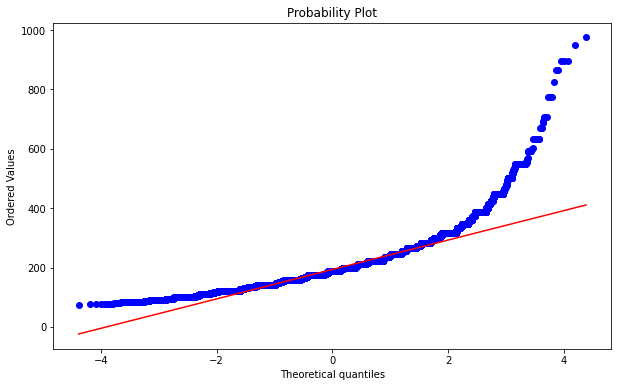

In [13]:
sqrt_feature = np.sqrt(train_data['monthly_income'].abs())

plt.figure(figsize=(12, 6))
plt.title('SQRT Monthly Income')
sns.distplot(sqrt_feature, fit=norm)

plt.figure(figsize=(10, 6))
stats.probplot(sqrt_feature, plot=plt);

**Squre Root transformation has showed worse results in comparison with log transformation**

Select log transformation

In [14]:
# Define a function for log transformation
def log_transform(df, columns):
    for column in columns:
        df[column] = np.log(df[column] + constant)
    return df

In [15]:
# Apply log transformation
columns_to_log = ['credit_sum', 'monthly_income', 'age']

train_data = log_transform(train_data, columns_to_log)
test_data = log_transform(test_data, columns_to_log)

### Feature Engineering 
let's create new features. For binary classification a feature is usefull **if it allows distinguish between positive and negative class**

We will apply binning and use `WoE` and `Information Value` metrics to quantify the feature power/usefulness in distinguishing between classes

In [16]:
# Bin numeric 'credit_month' feature (i.e. transform into a categorical)
bins = [
    -np.inf, 7.95, 9.6, 11.25, 13.725, 14.55, 
    17.85, 20.325, 23.625, 24.45, 26.925, np.inf
       ]

print('Unique credit_month values: \n', train_data['credit_month'].unique())

# Bin the feature
train_data['month_cats'] = pd.cut(train_data['credit_month'], bins=bins)
test_data['month_cats'] = pd.cut(test_data['credit_month'], bins=bins)

Unique credit_month values: 
 [12 10  3 32  6 24 18  5 14  4 13  9  8 16 20 36 15  7 11 28 22 26 21 19
 17 30 23 25 27 29]


In [17]:
# Now build Conjugacy table between 'month_cats' and 'open_account_flg'
cross_table = pd.crosstab(train_data['month_cats'], train_data['open_account_flg'])
cross_table

open_account_flg,0,1
month_cats,,
"(-inf, 7.95]",7151,2393
"(7.95, 9.6]",924,213
"(9.6, 11.25]",57822,9470
"(11.25, 13.725]",25361,7068
"(13.725, 14.55]",1698,124
"(14.55, 17.85]",348,116
"(17.85, 20.325]",1426,718
"(20.325, 23.625]",20,0
"(23.625, 24.45]",3366,946


With the help of cross table we can calculate the weight of each category (i.e. we can weight it). 

For this purpose we use `WoE` value 

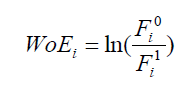

- `i`: category
- `numerator`: relative frequency of those who didn't open a bank account
- `denomenator`: relative frequency of those who opened a bank account 

`WoE` **measures the predictive power of each category**. There are some limitations when using `WoE`:
- Missing values are grouped into a separate category
- Each category must have no less than 5 % of total observations
- Category cannot have zero observations 


**The main idea when dealing with `WoE` - find and separate categories that allow separating target classes**

**Categories/groups with the same `WoE` values unite because these categories show the same behaviour between target classes**

Besides, it's **important to look at the `WoE` value difference between groups.** The more the difference, the more predictive power a feature has

In [18]:
# Calculate WoE for each group in cross_table
def calculate_woe(cross_table):
    constant = 0.0001
    F_0 = cross_table[0]/sum(cross_table[0] + constant)
    F_1 = cross_table[1]/sum(cross_table[1] + constant)
    woe_values = np.log(F_0/F_1) 
    woe_values = woe_values.replace([-np.inf, np.inf], 0)
    return woe_values

In [19]:
cross_table_woe = calculate_woe(cross_table)
cross_table_woe

month_cats
(-inf, 7.95]       -0.443
(7.95, 9.6]        -0.070
(9.6, 11.25]        0.271
(11.25, 13.725]    -0.260
(13.725, 14.55]     1.079
(14.55, 17.85]     -0.439
(17.85, 20.325]    -0.852
(20.325, 23.625]    0.000
(23.625, 24.45]    -0.269
(24.45, 26.925]     0.254
(26.925, inf]      -0.458
dtype: float64

Now, let's find out **how a feature will be useful for the model.** For this purpose, we calculate `Information Value`.

**Information Value can be calculated for a separate category or for the entire feature**

The formula for calculating `Information Value` for each category:

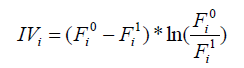

In [20]:
def calculate_categorical_information_value(cross_table):
    """
    Calculates Information Value for each category/group in a cross table 
    
    """
    constant = 0.0001
    F_0 = cross_table[0]/sum(cross_table[0] + constant)
    F_1 = cross_table[1]/sum(cross_table[1] + constant)
    info_value = (F_0 - F_1) * np.log(F_0/F_1)
    info_value = info_value.replace([-np.inf, np.inf], 0)
    return info_value

In [21]:
cross_table_info_value = calculate_categorical_information_value(cross_table)
cross_table_info_value

month_cats
(-inf, 7.95]       0.018
(7.95, 9.6]        0.000
(9.6, 11.25]       0.038
(11.25, 13.725]    0.020
(13.725, 14.55]    0.012
(14.55, 17.85]     0.001
(17.85, 20.325]    0.017
(20.325, 23.625]   0.000
(23.625, 24.45]    0.003
(24.45, 26.925]    0.000
(26.925, inf]      0.001
dtype: float64

`Information Value` can be calculated for the entire feature. **In this case, information values for each category are summed up**

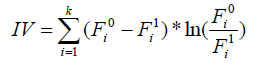

**Information Value is always positive and the are some gradations for values**
- ` x < 0.02`: useless
- `0.02 < x < 0.1`: weak
- `0.1 < x < 0.3`: average predictive power
- `x > 0.3`: powerful 

**Important**
- `Information Values` more than 0.5 are suspicious and further analysis must be applied for them

In [22]:
# Total Information Value for 'month_cats' feature
print('month_cats Information Value: ', cross_table_info_value.sum())

month_cats Information Value:  0.10913308429400476


The feature has avg predictive power. Let's calculate information value for other features

In [23]:
def define_info_value_usefulness(x):
    if x > 0.5:
        return 'Suspiciously High'
    elif x <= 0.5 and x > 0.3:
        return 'High'
    elif x <= 0.3 and x > 0.1:
        return 'Average'
    elif x <= 0.1 and x > 0.02:
        return 'Weak'
    else:
        return 'Useless'

def calculate_information_value_features(df, target_name):
    """
    Calculates Information Value for features
    
    df: pd.DataFrame
        DataFrame with features
        
    target: pd.Series
        Target feature (binary)
        
    """
    constant = 0.0001
    iv_feature_values = []
    target = df[target_name]
    df = df.drop(target_name, axis=1)
    
    for column in df.columns:
        cross_table = pd.crosstab(df[column], target)
        cat_info_value = calculate_categorical_information_value(cross_table)
        iv_feature_values.append(sum(cat_info_value))
        
    res_df = pd.DataFrame({'Feature':  df.columns, 'Info_Value': iv_feature_values})
    res_df['Usefulness'] = res_df['Info_Value'].apply(define_info_value_usefulness)
    res_df = res_df.sort_values(by='Info_Value', ascending=False)
    return res_df

In [24]:
info_values_features_df = calculate_information_value_features(train_data, target_name='open_account_flg')
info_values_features_df

,Feature,Info_Value,Usefulness
4,credit_sum,0.577,Suspiciously High
7,score_shk,0.453,High
6,tariff_id,0.266,Average
9,living_region,0.120,Average
5,credit_month,0.115,Average
14,month_cats,0.109,Average
1,age,0.093,Weak
13,is_overdue_credit_count_missing,0.084,Weak
3,job_position,0.053,Weak
8,education,0.049,Weak


We can see from the above table that **the most powerful feature is `credit_sum` and the weakest - `overdue_credit_count`**

New feature `month_cats` has average predictive power.

`Information Value` can be only used to eliminate useless features. We should not rely on these values to select the most powerful features. Because features should be selected based on how they interact with each other. In addition, `Information Value` depends on the size of a category (i.e. the more the category size, the more the information value is)

### Feature Importance Using Random Forest
Let's build *Random Forest model* and find out feature importances

In [25]:
# Prepare the features
def split_features(df, target_name):
    """
    Splits features according to their type (e.g. numeric, binary and categorical)
    
    df: pd.DataFrame
        DataFrame with features
    target_name: str
        Name of the target feature
        
    Retruns: tuple
        Binary, Categorical and Numeric features
    """
    df = df.drop(columns=target_name)
    
    # Categorical and binary feature selection
    object_features_df = df.select_dtypes(['object', 'category']).describe()
    bin_features = object_features_df.columns[object_features_df.loc['unique'] == 2].to_list()
    cat_features = object_features_df.columns.difference(bin_features).to_list()
    
    # Numeric feature selection
    num_features = df.columns.difference(bin_features + cat_features).to_list()
    return bin_features, cat_features, num_features


def encode_binary_features(df):
    """
    Encodes binary features by 0 and 1
    
    """
    for column in df.columns:
        values_to_encode = list(df[column].unique())
        df[column] = df[column].map({values_to_encode[0]: 0, values_to_encode[1]: 1})
    return df


def scale_num_features(df, scaler, scale_test=False):
    if not scale_test:
        num_features_scaled = scaler.fit_transform(df)
    else:
        num_features_scaled = scaler.transform(df)
        
    num_features_scaled = pd.DataFrame(num_features_scaled, index=df.index, columns=df.columns)
    return num_features_scaled, scaler

In [26]:
# Split the features
bin_columns, cat_columns, num_columns = split_features(
    train_data, target_name=TARGET_FEATURE_NAME
)

# Train Processing
target_train = train_data[TARGET_FEATURE_NAME]
binary_features_enc = encode_binary_features(train_data[bin_columns])
cat_features_enc = pd.get_dummies(train_data[cat_columns], drop_first=True)

num_features_scaled, fitted_scaler = scale_num_features(
    train_data[num_columns],
    scale_test=False,
    scaler=RobustScaler()
)

features_to_concat = [
    binary_features_enc, cat_features_enc, num_features_scaled, target_train
]
train_data_enc = pd.concat(features_to_concat, axis='columns')

In [27]:
# Train/Test data
X_train = train_data_enc.drop(columns='open_account_flg')
y_train = train_data_enc['open_account_flg']

forest_model = RandomForestClassifier(
    n_estimators=800,
    max_depth=17,
    random_state=23,
    n_jobs=-1
)

forest_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=17, n_estimators=800, n_jobs=-1,
                       random_state=23)

In [28]:
rm_forest_fi = pd.DataFrame(
    {
        'Feature': X_train.columns,
        'Importance': forest_model.feature_importances_
    }
)
rm_forest_fi = rm_forest_fi.sort_values('Importance', ascending=False)
rm_forest_fi.head(10)

,Feature,Importance
322,tariff_id_1.32,0.119
337,credit_sum,0.086
334,age,0.077
340,score_shk,0.072
1,is_overdue_credit_count_missing,0.056
303,"month_cats_(9.6, 11.25]",0.047
336,credit_month,0.045
338,monthly_income,0.042
335,credit_count,0.029
312,tariff_id_1.1,0.029


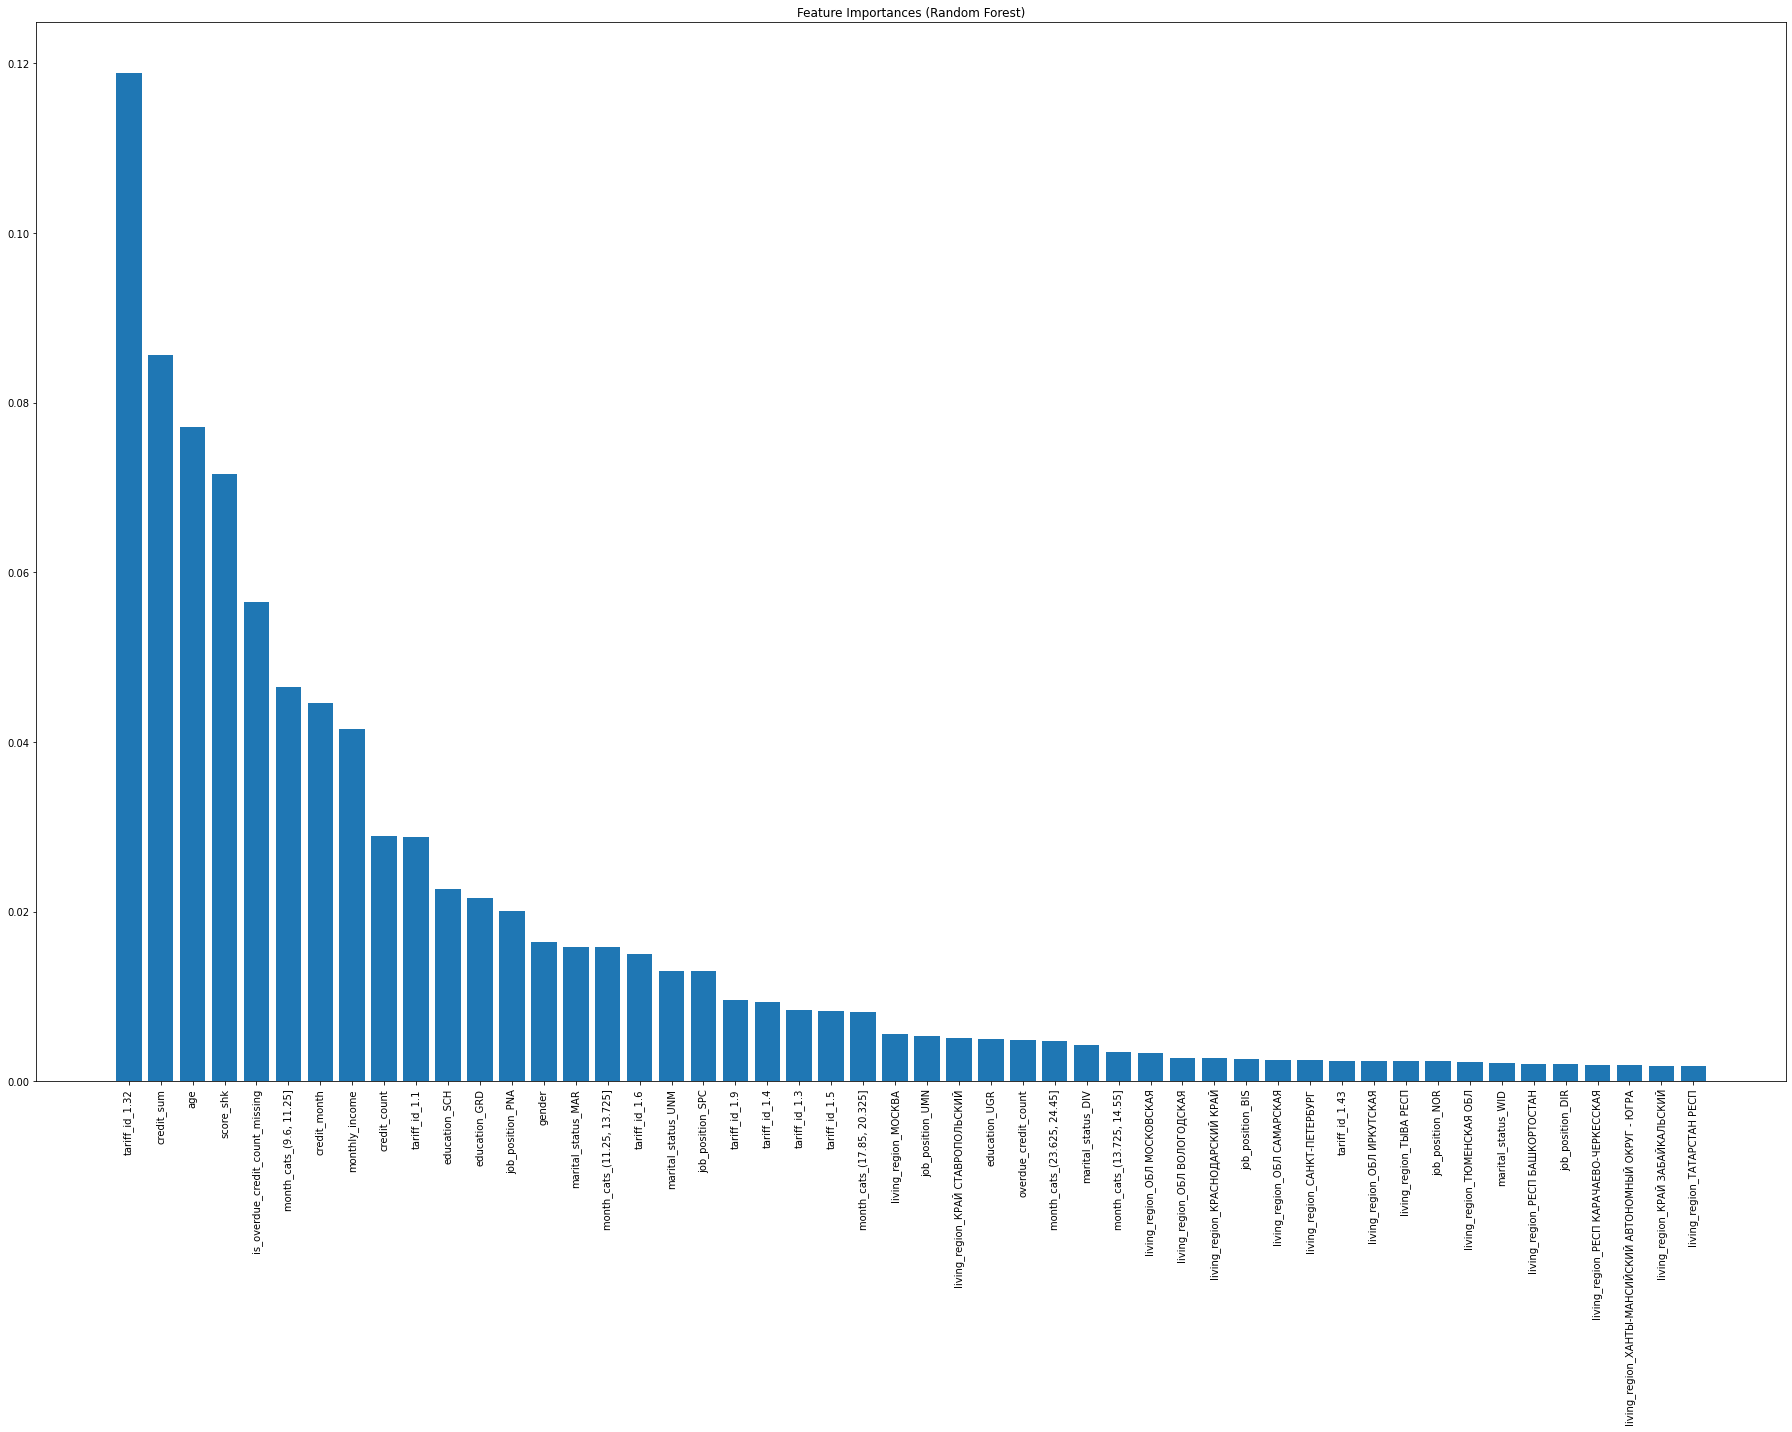

In [29]:
plt.figure(figsize=(25, 20))
plt.title('Feature Importances (Random Forest)')
plt.xticks(rotation=90)
plt.bar(rm_forest_fi['Feature'].values[:50], rm_forest_fi['Importance'][:50])
plt.tight_layout();

### Feature Engineering 
Let's generate new features

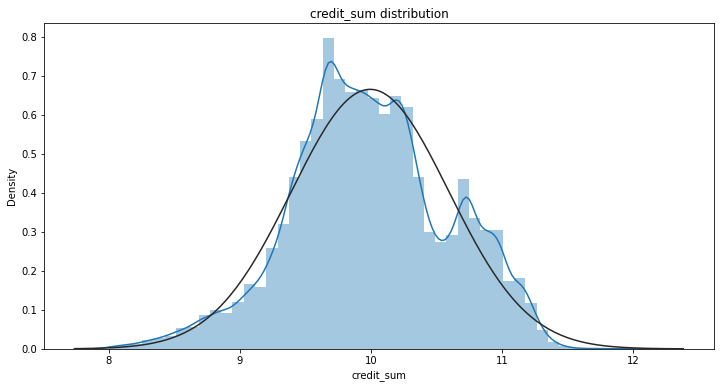

In [30]:
plt.figure(figsize=(12, 6))
plt.title('credit_sum distribution')
sns.distplot(train_data['credit_sum'], fit=norm);

In [31]:
def generate_features(df):
    # 1. Bin feature: credit_sum
    bins = [
        -np.inf, 8.343, 8.558, 8.880, 8.987,
        9.309, 9.416, 9.631, 9.738, 9.953,
        10.167, 10.275, 10.489, 10.704, 11.133,
        11.348, 11.562, np.inf
    ]
    df['cred_sum_cat'] = pd.cut(df['credit_sum'], bins)
    
    # 2. Create feature: how much a client must pay per month
    df['pay_per_month'] = df['credit_sum'] / df['credit_month']
    
    # 3. Bin feature: pay_per_month
    bins = [
        -np.inf, 0.42, 0.52, 0.70, 0.88,
        1.06, 1.16, 1.52, 1.70, 1.98,
        2.25, 2.34, 2.62, 2.89, np.inf
    ]
    df['pay_per_month_cats'] = pd.cut(df['pay_per_month'], bins)
    
    # 4. Create feature: pay_per_month / monthly_income
    df['pti'] = df['pay_per_month'] / df['monthly_income']
    df['pti'][df['pti'] == np.inf] = 1
    
    # 4. Squre some features
    columns_to_squre = [
        'age', 'credit_sum', 'score_shk',
        'monthly_income', 'credit_month', 'credit_count'
    ]
    for column in columns_to_squre:
        df[column + '_sq'] = df[column]**2 
    return df

In [32]:
# Create new features
train_data = generate_features(train_data)
test_data = generate_features(test_data)

In [33]:
# Train data Info
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119522 entries, 41202 to 29204
Data columns (total 26 columns):
 #   Column                           Non-Null Count   Dtype   
---  ------                           --------------   -----   
 0   gender                           119522 non-null  object  
 1   age                              119522 non-null  float64 
 2   marital_status                   119522 non-null  object  
 3   job_position                     119522 non-null  object  
 4   credit_sum                       119522 non-null  float64 
 5   credit_month                     119522 non-null  int64   
 6   tariff_id                        119522 non-null  object  
 7   score_shk                        119522 non-null  float64 
 8   education                        119522 non-null  object  
 9   living_region                    119522 non-null  object  
 10  monthly_income                   119522 non-null  float64 
 11  credit_count                     119522 non-null 

In [34]:
# Split the features
bin_columns, cat_columns, num_columns = split_features(train_data, target_name=TARGET_FEATURE_NAME)

In [35]:
# Train Processing
target_train = train_data[TARGET_FEATURE_NAME]
binary_features_enc = encode_binary_features(train_data[bin_columns])
cat_features_enc = pd.get_dummies(train_data[cat_columns], drop_first=True)

num_features_scaled, fitted_scaler = scale_num_features(
    train_data[num_columns],
    scale_test=False,
    scaler=RobustScaler()
)

features_to_concat = [
    binary_features_enc, cat_features_enc, num_features_scaled, target_train
]
train_data_enc = pd.concat(features_to_concat, axis='columns')

# Test Processing
target_test = test_data[TARGET_FEATURE_NAME]
binary_features_enc = encode_binary_features(test_data[bin_columns])
cat_features_enc = pd.get_dummies(test_data[cat_columns], drop_first=True)
num_features_scaled, fitted_scaler = scale_num_features(
    test_data[num_columns],
    scale_test=True,
    scaler=fitted_scaler
)

features_to_concat = [
    binary_features_enc, cat_features_enc, num_features_scaled, target_test
]
test_data_enc = pd.concat(features_to_concat, axis='columns')

**Some categories are not present in test data. Thus, use only common columns**

In [36]:
common_columns = set(train_data_enc.columns).intersection(test_data_enc.columns)
train_data_enc = train_data_enc[common_columns]
test_data_enc = test_data_enc[common_columns]

assert train_data_enc.shape[1] == test_data_enc.shape[1]
print('Feature shape is correct!')

Feature shape is correct!


In [37]:
# Train/Test data
X_train = train_data_enc.drop(columns='open_account_flg')
y_train = train_data_enc['open_account_flg']

X_test = test_data_enc.drop(columns='open_account_flg')
y_test = test_data_enc['open_account_flg']

### Logistic Regression Model

In [38]:
# Logistic Regression 
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)

LogisticRegression()

In [39]:
# Logistic Regression predictions
log_reg_target_class_proba_train = log_reg_model.predict_proba(X_train)[:, 1]
log_reg_target_class_proba_test = log_reg_model.predict_proba(X_test)[:, 1]

# Metrics results
log_reg_auc_train = roc_auc_score(y_train, log_reg_target_class_proba_train)
log_reg_auc_test = roc_auc_score(y_test, log_reg_target_class_proba_test)

print('ROC-AUC Logistic Regression Train: ', log_reg_auc_train)
print('ROC-AUC Logistic Regression Test: ', log_reg_auc_test)

ROC-AUC Logistic Regression Train:  0.7612546699598812
ROC-AUC Logistic Regression Test:  0.7487863482204277


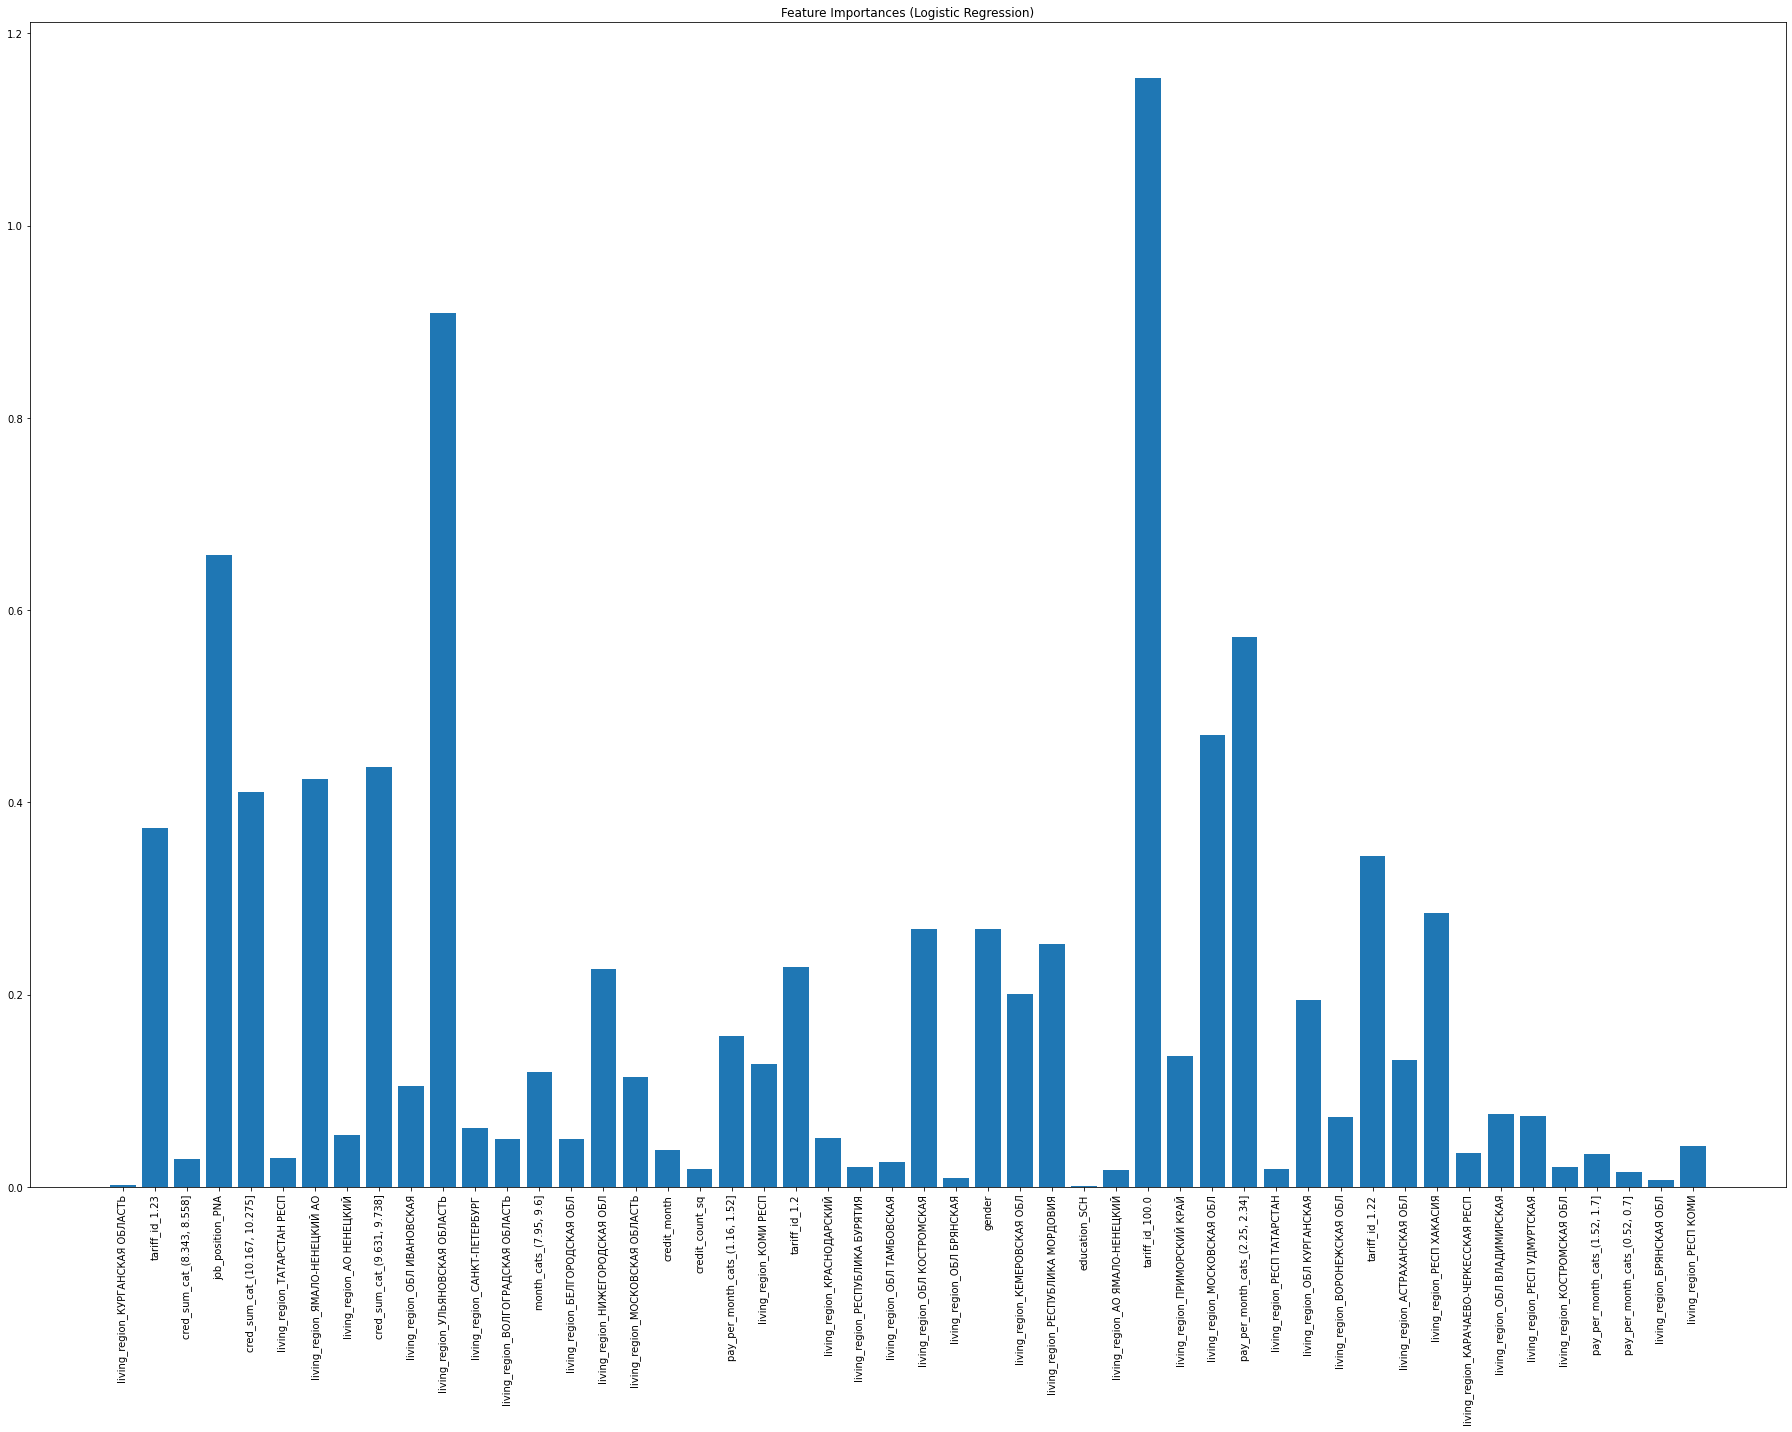

In [40]:
plt.figure(figsize=(25, 20))
plt.title('Feature Importances (Logistic Regression)')
plt.xticks(rotation=90)
plt.bar(train_data_enc.columns[:50], abs(log_reg_model.coef_.reshape(-1)[:50]))
plt.tight_layout();

### Feature Selection
This step is usually done **after preprocessing** (i.e have no missing values and the data is encoded and scaled)


### Filter Methods
Let's cover the following techniques:
- `SelectKBest` or `SelectPercentile` (Univariate Analysis)
- `Variance Threshold`
- `Correlation (Pearson, V-Crammer, ...)`

### SelectKBest 
The method uses statistical calculations under the hood. `SelectKBest` takes a certain `score_func` and runs univariate statistical tests depending on which `score_func` we use. **The most used score functions:**
- `f_classif`: ANOVA F-value between target/feature (classification)
- `mutual_info_classif`: Mutual information for a discrete target (classification)
- `chi2`: Chi-squared stats on non-negative features (classification)


- `f_regression`: F-Value between target/feature (regression)
- `mutual_info_regression`: Mutual information for a continuous target (regression)


In [41]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2
import tqdm

N_FEATURES_TO_SELECT = 10

### F - value

The methods based on F-test **estimate the degree of linear dependency between two random variables. They assume a linear relationship between the feature and the target.** These methods also assume that the variables follow a Gaussian distribution.


- **Categorical Features:** calculate a chi-square statistic between each feature and the target vector.
- **Numeric Feature:** compute the ANOVA F-value between each feature and the target vector (how means for each group are significantly different)


In [42]:
%%time
# Select to N features using `score_func=f_classif`
feature_selector = SelectKBest(score_func=f_classif, k=N_FEATURES_TO_SELECT)  
feature_selector.fit(X_train, y_train)

selected_features = X_train.columns[feature_selector.get_support()]
feature_scores = feature_selector.scores_[feature_selector.get_support()]

f_scores_df = pd.DataFrame({'F_Score': feature_scores}, index=selected_features).sort_values('F_Score', ascending=False)
f_scores_df.head(10)

Wall time: 546 ms


,F_Score
tariff_id_1.32,3450.353
is_overdue_credit_count_missing,1924.927
"month_cats_(9.6, 11.25]",1396.498
"pay_per_month_cats_(1.06, 1.16]",933.895
credit_sum,843.353
credit_sum_sq,824.424
education_GRD,804.547
education_SCH,738.541
job_position_PNA,715.460
"month_cats_(11.25, 13.725]",518.600


In [43]:
# Select only top N features
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

In [44]:
# Logistic Regression 
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train_sel, y_train)

# Logistic Regression predictions
log_reg_target_class_proba_train = log_reg_model.predict_proba(X_train_sel)[:, 1]
log_reg_target_class_proba_test = log_reg_model.predict_proba(X_test_sel)[:, 1]

# Metrics results
log_reg_auc_train = roc_auc_score(y_train, log_reg_target_class_proba_train)
log_reg_auc_test = roc_auc_score(y_test, log_reg_target_class_proba_test)

print('ROC-AUC Logistic Regression Train: ', log_reg_auc_train)
print('ROC-AUC Logistic Regression Test: ', log_reg_auc_test)

ROC-AUC Logistic Regression Train:  0.7079871860883188
ROC-AUC Logistic Regression Test:  0.7088166511023017


We see that **top-10 features provide us with not the best model quality.** Quality has dropped down dramatically. Thus, an important question is **how the performance of the model is affected by the number of the best features.**

For this reason let's plot the following graph:

In [45]:
%%time

f_classif_roc_auc_train = []
f_classif_roc_auc_test = []

# score_func = f_classif
for k in tqdm.trange(1, train_data_enc.shape[1]):
    feature_selector = SelectKBest(score_func=f_classif, k=k)  
    feature_selector.fit(X_train, y_train)
    selected_features = X_train.columns[feature_selector.get_support()]
    
    X_train_sel = X_train[selected_features]
    X_test_sel = X_test[selected_features]
    
    # Logistic Regression 
    log_reg_model = LogisticRegression()
    log_reg_model.fit(X_train_sel, y_train)

    # Logistic Regression predictions
    log_reg_target_class_proba_train = log_reg_model.predict_proba(X_train_sel)[:, 1]
    log_reg_target_class_proba_test = log_reg_model.predict_proba(X_test_sel)[:, 1]
    
    f_classif_roc_auc_train.append(roc_auc_score(y_train, log_reg_target_class_proba_train))
    f_classif_roc_auc_test.append(roc_auc_score(y_test, log_reg_target_class_proba_test))

100%|██████████| 335/335 [16:29<00:00,  2.95s/it]

Wall time: 16min 29s


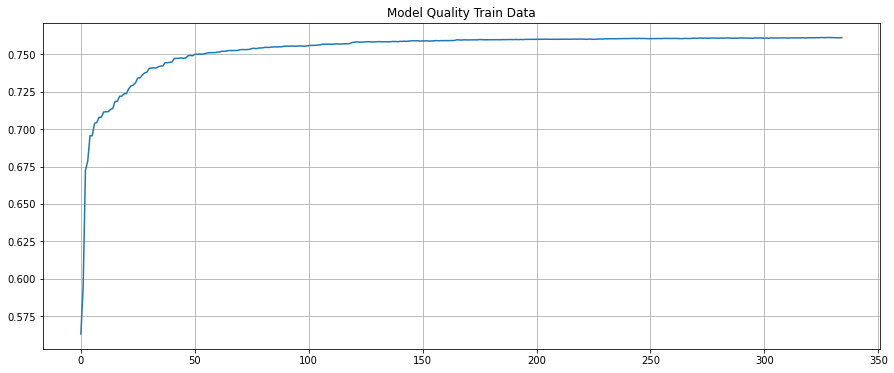

In [46]:
plt.figure(figsize=(15, 6))
plt.title('Model Quality Train Data')
plt.plot(f_classif_roc_auc_train)
plt.grid()

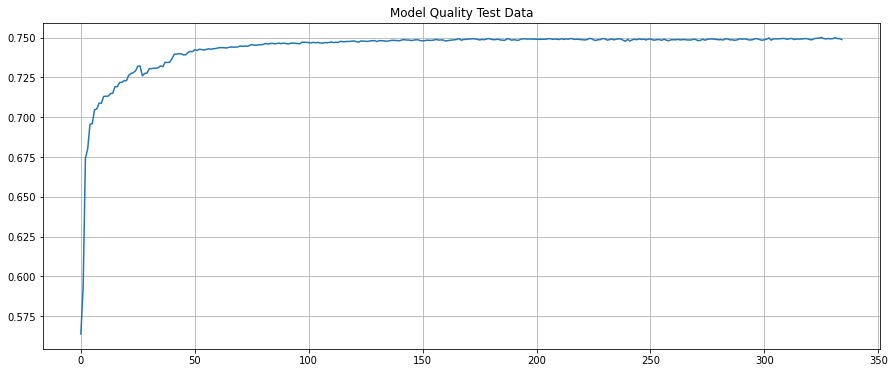

In [47]:
plt.figure(figsize=(15, 6))
plt.title('Model Quality Test Data')
plt.plot(f_classif_roc_auc_test)
plt.grid()

We can see that after 200 features quality doesn't improve. Let's find number of features that provides the best model quality

In [48]:
roc_auc_best_train = max(f_classif_roc_auc_train)
roc_auc_best_test = max(f_classif_roc_auc_test)

max_indx_train = f_classif_roc_auc_train.index(roc_auc_best_train)
max_indx_test = f_classif_roc_auc_test.index(roc_auc_best_test)

print('Best ROC-AUC Train: ', roc_auc_best_train)
print('Best ROC-AUC Test: ', roc_auc_best_test)

Best ROC-AUC Train:  0.7613634579674606
Best ROC-AUC Test:  0.7500949640423994


**We should use only results obtained from train data. Thus, optimal number of features is `328`**

### Mutual Information (MI)
Let's now use `mutual_information` criterion. 

- `Mutual Information` is a measure of **dependence** or **mutual dependence** between two random variables `X` and `Y`. It measures the amount of information obtained about one variable through observing the other one. In other words, it determines how much we can know about one varible by observing/understanding another variable.

- In ML `Mutual Information` measures how much information (presence/absence) of a feature contributes to making a correct prediction on `Y`
- `Mutual Information (MI)` cannot be negative and the higher the value, the more dependecy is.

`MI(X, Y) = H(X) - H(X | Y)` and `MI(X, Y) = MI(Y, X)`

More info: https://www.youtube.com/watch?v=YKDZHPJ-pQ0

`Mutual Information` methods **can capture any kind of statistical dependency**, but being nonparametric, they require more samples for accurate estimation.

In [67]:
%%time
# Select to N features using `score_func=mutual_info_classif`
feature_selector = SelectKBest(score_func=mutual_info_classif, k=N_FEATURES_TO_SELECT)  
feature_selector.fit(X_train, y_train)

selected_features = X_train.columns[feature_selector.get_support()]
feature_scores = feature_selector.scores_[feature_selector.get_support()]

mi_scores_df = pd.DataFrame({'MI_Value': feature_scores}, index=selected_features).sort_values('MI_Value', ascending=False)
mi_scores_df.head(10)

Wall time: 5min 55s


,MI_Value
pay_per_month,0.027
credit_sum_sq,0.022
credit_sum,0.020
job_position_SPC,0.014
pti,0.014
"month_cats_(9.6, 11.25]",0.011
credit_month_sq,0.011
tariff_id_1.32,0.011
credit_month,0.010
marital_status_MAR,0.010


In [68]:
# Eliminate low variance features
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

# Logistic Regression 
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train_sel, y_train)

# Logistic Regression predictions
log_reg_target_class_proba_train = log_reg_model.predict_proba(X_train_sel)[:, 1]
log_reg_target_class_proba_test = log_reg_model.predict_proba(X_test_sel)[:, 1]

# Metrics results
log_reg_auc_train = roc_auc_score(y_train, log_reg_target_class_proba_train)
log_reg_auc_test = roc_auc_score(y_test, log_reg_target_class_proba_test)

print('ROC-AUC Logistic Regression Train: ', log_reg_auc_train)
print('ROC-AUC Logistic Regression Test: ', log_reg_auc_test)

ROC-AUC Logistic Regression Train:  0.6911574521897095
ROC-AUC Logistic Regression Test:  0.6930840141106307


### Chi Squared (Fisher Score)
It computes chi-squared stats between each **non-negative feature** and class/label. We cannot apply `chi2` criterion because it requires features to be positive. Thus, we ommit the method.

### Variance Threshold
`Variance threshold` is a simple baseline approach to select the features. Let's define a custom variance threshold and select the features 

In [46]:
from sklearn.feature_selection import VarianceThreshold

In [70]:
%%time
feature_selector = VarianceThreshold(threshold=0.01)
feature_selector.fit(X_train)

selected_features = X_train.columns[feature_selector.get_support()]
feature_scores = feature_selector.variances_[feature_selector.get_support()]

variance_scores_df = pd.DataFrame({'Variance': feature_scores}, index=selected_features).sort_values('Variance', ascending=False)
variance_scores_df.head(10)

Wall time: 450 ms


,Variance
credit_month_sq,6.866
credit_month,3.117
pay_per_month,2.936
pti,2.830
credit_count_sq,2.554
credit_count,0.745
credit_sum,0.609
credit_sum_sq,0.608
score_shk_sq,0.572
monthly_income_sq,0.530


We have a small problem - quadratic features, not surprisingly that they have much variance. However, for simplicity we will not eliminate them

In [71]:
# Eliminate low variance features
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

# Logistic Regression 
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train_sel, y_train)

# Logistic Regression predictions
log_reg_target_class_proba_train = log_reg_model.predict_proba(X_train_sel)[:, 1]
log_reg_target_class_proba_test = log_reg_model.predict_proba(X_test_sel)[:, 1]

# Metrics results
log_reg_auc_train = roc_auc_score(y_train, log_reg_target_class_proba_train)
log_reg_auc_test = roc_auc_score(y_test, log_reg_target_class_proba_test)

print('ROC-AUC Logistic Regression Train: ', log_reg_auc_train)
print('ROC-AUC Logistic Regression Test: ', log_reg_auc_test)

ROC-AUC Logistic Regression Train:  0.7538661737919812
ROC-AUC Logistic Regression Test:  0.7449913329159723


### Correlation
Any correlation analysis can be applied to find the dependency between a feature and the target. **The main idea** - features should be correlated with the target but uncorrelated among themselves!

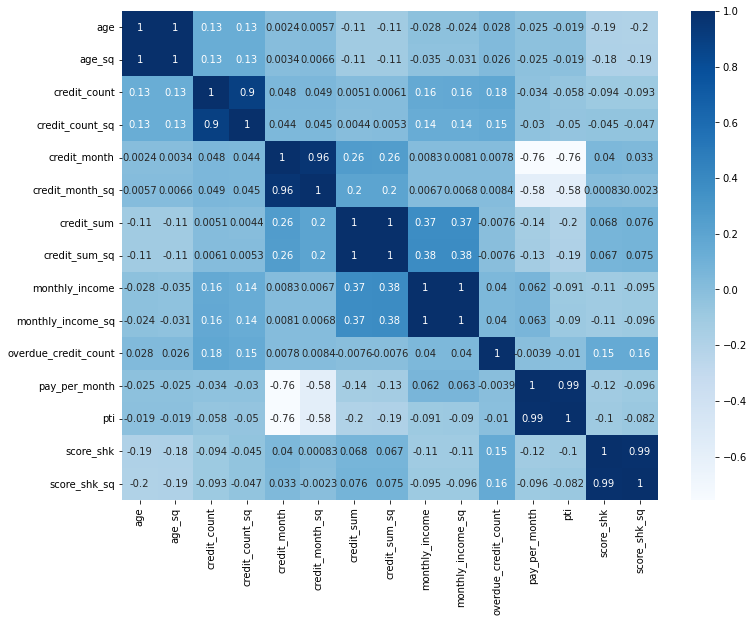

In [72]:
corr_matrix = train_data_enc[num_columns].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_matrix, cmap='Blues', annot=True, square=False, vmax=1.0, ax=ax);

We can see that **squared features** are correlated with its initial ones. Besides, features `pay_per_month` and `pti` use information from `credit_month` features and thus correlated. We don't see any red flags, thus will not drop any features.

**The target variable is binary, thus we cannot apply correlation.**

let's define correlation between numeric features and the target as group mathematical expectation difference.

In [73]:
def calculate_math_exp_differences(feat_df, target, ascending=False):
    """
    Calculates correlation between numerical features and a binary target
    
    feat_df: pd.DataFrame
        Main DataFrame with only numeric features
        
    target: pd.Series
        Target feature
        
    ascending: bool
        How to sort the final result
    
    """
    main_df = pd.concat([feat_df, target], axis=1) # for combining features with the target
    main_df = main_df.dropna() # DataFrame must be without NaN values because it affects the result
    
    mat_exp_diff = []
    for feature in feat_df.columns:
        group_means = main_df[[feature, target.name]].groupby(by=target.name).mean()
        means_diff = group_means.iloc[0, 0] - group_means.iloc[1, 0]
        mat_exp_diff.append(means_diff)
        
    df = abs(pd.DataFrame({'Corr_ME_diffs':mat_exp_diff}, index=feat_df.columns)).sort_values(by='Corr_ME_diffs', ascending=ascending)
    return df.sort_values(by='Corr_ME_diffs', ascending=ascending)

In [74]:
mat_exp_scores_df = calculate_math_exp_differences(feat_df=X_train[num_columns],
                                                   target=y_train)


mat_exp_scores_df.head(10)

,Corr_ME_diffs
credit_month_sq,0.242
credit_sum,0.171
credit_sum_sq,0.169
credit_month,0.127
credit_count_sq,0.105
score_shk_sq,0.105
score_shk,0.097
age,0.083
age_sq,0.076
credit_count,0.071


In [88]:
# let's find out common top-10 features 
f_set = set(f_scores_df.index)
mi_set = set(mi_scores_df.index)
variance_set = set(variance_scores_df.index)
mat_set = set(mat_exp_scores_df.index)

common_sel_features = f_set.intersection(mi_set).intersection(variance_set)

print('Common Selected Features: ', common_sel_features)

Common Selected Features:  {'tariff_id_1.32', 'credit_sum', 'credit_sum_sq', 'month_cats_(9.6, 11.25]'}


Now we are more sure that the features above are definitely useful and should be selected

### Wrapper Methods
In wrapper methods, we try to use a subset of features and train a model using them. Based on the inferences from the previous model, we decide to add or remove features from the current subset. **The method is computationally expensive.**

Some Methods:
- `Forward Selection`
- `Backward Elimination`
- `Exhaustive Feature Selection`
- `Recursive Feature Elimination`
- `Recursive Feature Elimination with cross-validation`

*The main idea of Wrapper Method*
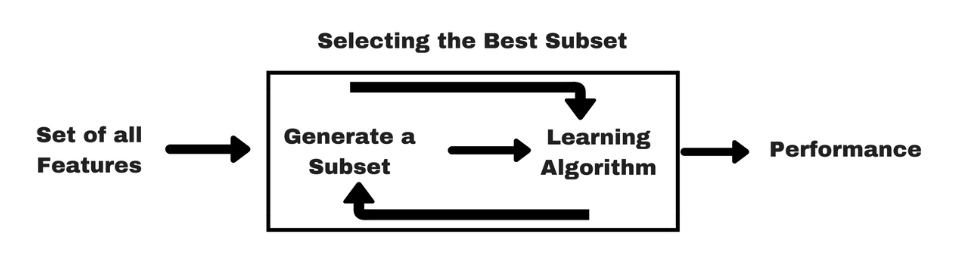

### Forward Selection
It is an iterative method in which **we start with having no features** in the model. In each iteration, we keep adding the feature which best improves our model till an addition of a new feature doesn't improve the model performance. This selection procedure is called greedy, because it evaluates all possible feature combinations. Therefore, **it is quite computationally expensive**, and sometimes, if feature space is big, even unfeasible.


In [47]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

The algorithm has a parameter `k_features` that can be set to a specific number.

In this case we can select top k-features that provide the best model quality on cross-validation.

In [47]:
%%time
log_reg_model = LogisticRegression()
fs_selector = SFS(
    log_reg_model,
    k_features=N_FEATURES_TO_SELECT,
    forward=True,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

fs_selector = fs_selector.fit(X_train, y_train)

In [107]:
print('Top 10 features: \n', list(X_train.columns[list(fs_selector.k_feature_idx_)]))

Top 10 features: 
 ['credit_sum', 'tariff_id_1.32', 'tariff_id_1.3', 'month_cats_(9.6, 11.25]', 'score_shk_sq', 'tariff_id_1.1', 'gender', 'job_position_PNA', 'marital_status_MAR', 'is_overdue_credit_count_missing']


**Again we see already known features from the previous methods**

### Backward Elimination
The algorithm **starts with all features** and removes the least significant feature at each iteration which improves the performance of the model. We repeat this until no improvement is observed on removal of features.

To use the alogorithm, set the paramter `forward=False` in `SequentialFeatureSelector`

### Exhaustive Feature Selection
In exhaustive feature selection, the performance of a machine learning algorithm is evaluated against all possible combinations of the features in the dataset. The feature subset that yields best performance is selected. The exhaustive search algorithm is the most greedy algorithm of all the wrapper methods since it tries all the combination of features and selects the best.

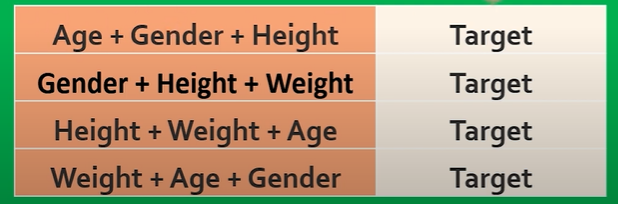

### Recursive Feature Elimination 
Recursive feature elimination (RFE) is a feature selection method that fits a model and removes the weakest feature (or features) until the specified number of features is reached. Features are ranked by the model’s `coef_` or `feature_importances_` attributes, and by recursively eliminating a small number of features per loop, RFE attempts to eliminate dependencies and collinearity that may exist in the model

In [110]:
from sklearn.feature_selection import RFE, RFECV

Examples for these methods will omitted

### Embedded Methods
These methods rely on ML-models and features can be selected using according to a certain feature importance threshold. Besides, regularization can be applied
- Lasso/Ridge
- Model Feature Importance 


In [48]:
from sklearn.feature_selection import SelectFromModel

In [51]:
%%time
# Select features using L1 regularization
feature_selector = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='saga'))
feature_selector.fit(X_train, y_train)

Wall time: 50 s


SelectFromModel(estimator=LogisticRegression(C=1, penalty='l1', solver='saga'))

In [68]:
selected_features = X_train.columns[feature_selector.get_support()]
feature_scores = abs(feature_selector.estimator_.coef_[0][feature_selector.get_support()])

from_model_scores_df = pd.DataFrame({'Coeff': feature_scores}, index=selected_features).sort_values('Coeff', ascending=False)
from_model_scores_df.head(10)

,Coeff
tariff_id_1.32,2.231
tariff_id_1.91,1.474
living_region_КРАЙ СТАВРОПОЛЬСКИЙ,1.232
age,1.068
living_region_ТЫВА РЕСП,1.054
tariff_id_100.0,0.986
tariff_id_1.3,0.929
score_shk_sq,0.920
is_overdue_credit_count_missing,0.892
age_sq,0.817


In [72]:
# How many features were selected
print('N Selected Features: ', from_model_scores_df.shape[0])

N Selected Features:  276


In [73]:
# Eliminate low variance features
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

# Logistic Regression 
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train_sel, y_train)

# Logistic Regression predictions
log_reg_target_class_proba_train = log_reg_model.predict_proba(X_train_sel)[:, 1]
log_reg_target_class_proba_test = log_reg_model.predict_proba(X_test_sel)[:, 1]

# Metrics results
log_reg_auc_train = roc_auc_score(y_train, log_reg_target_class_proba_train)
log_reg_auc_test = roc_auc_score(y_test, log_reg_target_class_proba_test)

print('ROC-AUC Logistic Regression Train: ', log_reg_auc_train)
print('ROC-AUC Logistic Regression Test: ', log_reg_auc_test)

ROC-AUC Logistic Regression Train:  0.7612576247968093
ROC-AUC Logistic Regression Test:  0.7495627853208484


We got relatively good quality

### Permutation Importance
The value shows how a feature is usefull after randomly shuffling it!

In [79]:
import eli5
from eli5.sklearn import PermutationImportance

In [82]:
%%time
log_reg_model = LogisticRegression()
per_imp = PermutationImportance(log_reg_model, random_state=23, cv=None)

per_imp.fit(X_train, y_train)

Wall time: 1min 59s


PermutationImportance(cv=None, estimator=LogisticRegression(), random_state=23)

In [85]:
eli5.show_weights(per_imp, feature_names=X_train.columns.to_list())

Weight,Feature
0.0313 ± 0.0015,age
0.0269 ± 0.0005,tariff_id_1.32
0.0268 ± 0.0017,score_shk_sq
0.0201 ± 0.0018,age_sq
0.0183 ± 0.0006,pay_per_month
0.0137 ± 0.0005,pti
0.0094 ± 0.0010,score_shk
0.0065 ± 0.0002,"month_cats_(9.6, 11.25]"
0.0046 ± 0.0005,tariff_id_1.1
0.0044 ± 0.0004,is_overdue_credit_count_missing


### SHAP Values

In [86]:
import shap

In [90]:
%%time
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)

explainer = shap.LinearExplainer(log_reg_model, X_train, feature_dependence="independent")
shap_values = explainer.shap_values(X_test)

Wall time: 3.65 s


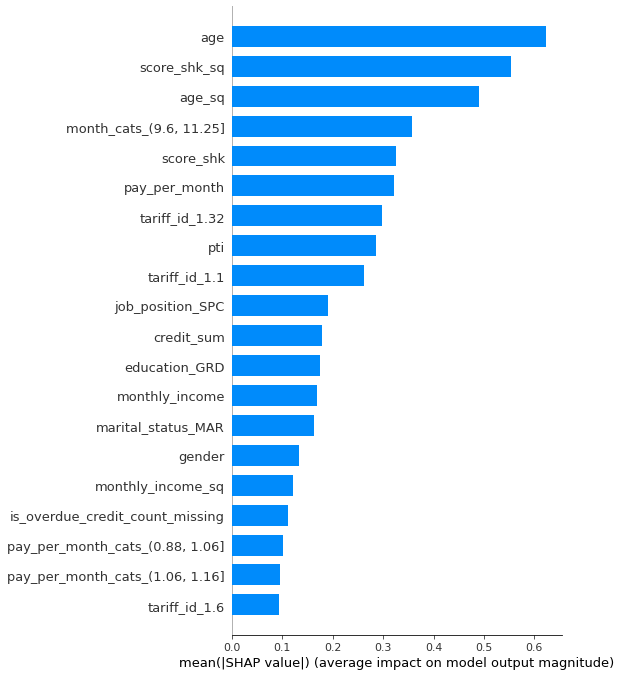

In [93]:
shap.summary_plot(shap_values,
                  X_test,
                  feature_names=X_test.columns,
                  plot_type='bar')

### Conclusion
We ended up with 335 features and got `ROC-AUC: 0.748`. Let's apply some feature selection techniques and try to improve the quality

### Correlation
Variables should be correlated with the target but uncorrelated among themselves

In [ ]:
# Let's find and drop numeric correlated features
corr_matrix = train_data_enc[num_columns].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_matrix, vmax=1.0, square=True);

In [ ]:
def drop_cor_features(df, thresh=0.8):
    """
    Finds and drops correlated features using Pearson correlation
    
    df: pd.DataFrame
    
    thresh: float
        Cut-off value 
    
    """
    corr_matrix = df.corr()
    corr_features = set()

    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) >= thresh:
                col_name = corr_matrix.columns[i]
                corr_features.add(col_name)
        
    print('Original Number of Features: ', df.shape[1])
    print('Number of Higly Correlated Features: ', len(corr_features))
    df.drop(columns=corr_features, inplace=True)    
    return df

In [ ]:
num_columns = drop_cor_features(train_data[num_columns]).columns

In [ ]:
# Train Processing
target_train = train_data[TARGET_FEATURE_NAME]
binary_features_enc = encode_binary_features(train_data[bin_columns])
cat_features_enc = pd.get_dummies(train_data[cat_columns], drop_first=True)
num_features_scaled, fitted_scaler = scale_num_features(train_data[num_columns],
                                                        scale_test=False,
                                                        scaler=RobustScaler())

features_to_concat = [binary_features_enc, cat_features_enc, num_features_scaled, target_train]
train_data_enc = pd.concat(features_to_concat, axis='columns')

# Test Processing
target_test = test_data[TARGET_FEATURE_NAME]
binary_features_enc = encode_binary_features(test_data[bin_columns])
cat_features_enc = pd.get_dummies(test_data[cat_columns], drop_first=True)
num_features_scaled, fitted_scaler = scale_num_features(test_data[num_columns],
                                                        scale_test=True,
                                                        scaler=fitted_scaler)

features_to_concat = [binary_features_enc, cat_features_enc, num_features_scaled, target_test]
test_data_enc = pd.concat(features_to_concat, axis='columns')

common_columns = set(train_data_enc.columns).intersection(test_data_enc.columns)
train_data_enc = train_data_enc[common_columns]
test_data_enc = test_data_enc[common_columns]

assert train_data_enc.shape[1] == test_data_enc.shape[1]
print('Feature shape is correct!')

In [ ]:
# Train/Test data
X_train = train_data_enc.drop(columns='open_account_flg')
y_train = train_data_enc['open_account_flg']

X_test = test_data_enc.drop(columns='open_account_flg')
y_test = test_data_enc['open_account_flg']

# Logistic Regression 
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)

# Logistic Regression predictions
log_reg_target_class_proba_train = log_reg_model.predict_proba(X_train)[:, 1]
log_reg_target_class_proba_test = log_reg_model.predict_proba(X_test)[:, 1]

# Metrics results
log_reg_auc_train = roc_auc_score(y_train, log_reg_target_class_proba_train)
log_reg_auc_test = roc_auc_score(y_test, log_reg_target_class_proba_test)

print('ROC-AUC Logistic Regression Train: ', log_reg_auc_train)
print('ROC-AUC Logistic Regression Test: ', log_reg_auc_test)

**This method is not the best and may lead to decrease in quality**

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression   

In [ ]:
feature_selector = SelectKBest(score_func=f_regression, k=10)  